In [1]:
!pip install cellpose --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 35.7 MB/s eta 0:00:00


In [9]:
# @title Importar Librerias
import numpy as np
from cellpose import models, core, io, plot
from cellpose.utils import masks_to_outlines
from skimage import transform
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted
from google.colab import files
from ipywidgets import interact, FloatSlider, RadioButtons, Checkbox, HBox, VBox, Dropdown, IntSlider, Text
from skimage.measure import regionprops
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse


io.logger_setup() # run this to get printing of progress
from google.colab import drive
drive.mount('/content/drive')

from cellpose import models

model_path = "/content/drive/MyDrive/cellpose/Crispose"

model = models.CellposeModel(
    gpu=True,
    pretrained_model=model_path
)

print("Modelo cargado correctamente:", model_path)


#model = models.CellposeModel(gpu=True)

2025-11-24 00:17:23,564 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-11-24 00:17:23,568 [INFO] 
cellpose version: 	4.0.7 
platform:       	linux 
python version: 	3.12.12 
torch version:  	2.9.0+cu126
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2025-11-24 00:17:25,066 [INFO] ** TORCH CUDA version installed and working. **
2025-11-24 00:17:25,067 [INFO] >>>> using GPU (CUDA)
2025-11-24 00:17:30,583 [INFO] >>>> loading model /content/drive/MyDrive/cellpose/Crispose
Modelo cargado correctamente: /content/drive/MyDrive/cellpose/Crispose


Saving 1_A5_Bi2S3_02.tif to 1_A5_Bi2S3_02.tif


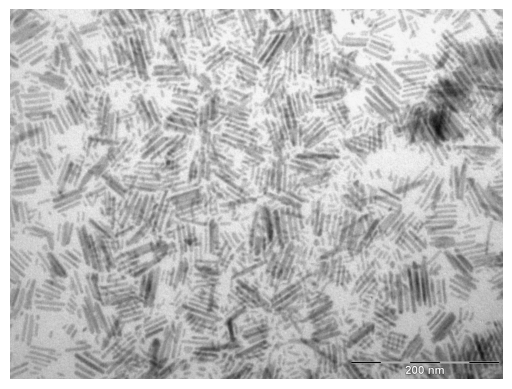

Imagen guardada como: 1_A5_Bi2S3_02.tif
Image shape: (1032, 1376)


In [36]:
# @title Subir Imagen
uploaded = files.upload()
image_name = list(uploaded.keys())[0]

img = io.imread(image_name)

h, w = img.shape[:2]
scale = 224 / max(h, w)
scale=1

new_h, new_w = int(h * scale), int(w * scale)

# Redimensionar proporcionalmente
img_resized = transform.resize(img, (new_h, new_w), anti_aliasing=True, preserve_range=True)
img = img_resized.astype(img.dtype)

plt.imshow(img,cmap="gray")
plt.axis('off')
plt.show()
print("Imagen guardada como:", image_name)
print(f'Image shape: {img.shape}')
if len(img.shape)==3:
  print(f'Channels: {img.shape[2]}')

In [37]:
# @title
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from cellpose import io
import numpy as np

# --- Widgets ---
umbral_slider = widgets.FloatSlider(
    min=0, max=1, step=0.1, value=0,
    description='Umbral detección',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False
)
norma_slider = widgets.FloatSlider(
    min=0, max=1, step=0.1, value=0,
    description='Normalización',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False
)
sens_slider = widgets.FloatSlider(
    min=0, max=1, step=0.1, value=1,
    description='Sensibilidad bordes',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False
)
status_label = widgets.Label("")
output_plot = widgets.Output()

# --- Función que actualiza ---
def procesar_cambios(change=None):
    global masks, flows, styles, outlines
    # Bloquear sliders y mostrar mensaje
    for s in [umbral_slider, norma_slider, sens_slider]:
        s.disabled = True
    status_label.value = "⏳ Procesando... espera unos segundos..."

    with output_plot:
        output_plot.clear_output(wait=True)

        # --- Ejecutar modelo ---
        img_selected_channels = img.copy()
        masks, flows, styles = model.eval(
            img_selected_channels,
            batch_size=32,
            flow_threshold=sens_slider.value,
            cellprob_threshold=umbral_slider.value,
            normalize={"tile_norm_blocksize": norma_slider.value}
        )

        outlines = masks_to_outlines(masks)

        # --- Mostrar resultado ---
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap='gray')
        plt.contour(outlines, colors='black', linewidths=0.8)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Desbloquear sliders
    for s in [umbral_slider, norma_slider, sens_slider]:
        s.disabled = False
    status_label.value = "Máscara procesada:"

# --- Conectar los sliders manualmente ---
for s in [umbral_slider, norma_slider, sens_slider]:
    s.observe(procesar_cambios, names='value')

# --- Mostrar interfaz ---
ui = widgets.VBox([
    umbral_slider, norma_slider, sens_slider, status_label, output_plot
])
display(ui)

# --- Ejecutar una vez al inicio ---
procesar_cambios()


In [38]:
# @title Control Visulización
# @title
variable_name = ""

# --- Precalcular regiones ---
props = regionprops(masks)
H, W = masks.shape

# Variables globales
DD = None
DD_err = None
hist_counts = None
hist_bins = None
diametros_region = None

def gauss(x, mu, sigma, A):
    """Función gaussiana"""
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


# --- Interfaz interactiva ---
def mostrar_region(tipo_medida, minr, maxr, minc, maxc, ancho, largo, mostrar_circulos, mostrar_numeros):
    global DD, DD_err, hist_counts, hist_bins, diametros_region

    # Convertir porcentajes a píxeles
    minr_px = int(H * minr / 100)
    maxr_px = int(H * maxr / 100)
    minc_px = int(W * minc / 100)
    maxc_px = int(W * maxc / 100)

    if minr_px >= maxr_px or minc_px >= maxc_px:
        print("⚠️ Región inválida: asegúrate de que Top < Bottom y Left < Right")
        return

    # Filtrar regiones dentro del área
    props_filtrados = [
        p for p in props
        if p.bbox[0] > minr_px and p.bbox[1] > minc_px and p.bbox[2] < maxr_px and p.bbox[3] < maxc_px
    ]
    N = len(props_filtrados)

    # Calcular medidas
    if tipo_medida == 'centroides':
        medidas = np.array([p.equivalent_diameter for p in props_filtrados])
        label_x = 'Diámetro equivalente (px)'
        datos = {'Diámetro': medidas}
        globals()['modo_region'] = 'Círculo'
        globals()['diametros_region'] = medidas

    else:
        datos = {}
        globals()['modo_region'] = 'Rectángulo'
        if ancho:
            anchos = np.array([p.minor_axis_length for p in props_filtrados])
            datos['Ancho'] = anchos
            globals()['anchos_region'] = anchos
        else:
            globals()['anchos_region'] = None

        if largo:
            largos = np.array([p.major_axis_length for p in props_filtrados])
            datos['Largo'] = largos
            globals()['largos_region'] = largos
        else:
            globals()['largos_region'] = None

        if not datos:
            print("⚠️ Selecciona al menos una medida (ancho o largo).")
            return


    # --- Figura principal ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.3, 1]})
    ax1.imshow(outlines, cmap='gray')

    rect = plt.Rectangle((minc_px, minr_px), maxc_px - minc_px, maxr_px - minr_px,
                         fill=False, edgecolor='white', linewidth=2)
    ax1.add_patch(rect)

    # Dibujar círculos/elipses si está activado
    if mostrar_circulos:
        for i, p in enumerate(props_filtrados, start=1):
            y, x = p.centroid
            if tipo_medida == 'centroides':
                r = p.equivalent_diameter / 2
                circ = plt.Circle((x, y), r, color='orange', fill=False, linewidth=1)
                ax1.add_patch(circ)
            else:
                y0, x0 = p.centroid
                width = p.minor_axis_length
                height = p.major_axis_length
                angle = -p.orientation * 180 / np.pi
                ellipse = Ellipse((x0, y0), width, height, angle=angle,
                                  edgecolor='orange', facecolor='none', linewidth=1)
                ax1.add_patch(ellipse)

            # Mostrar número solo si está activado
            if mostrar_numeros:
                ax1.text(x, y, str(i), color='yellow', fontsize=7, ha='center', va='center')

    ax1.set_title(f'{N} objetos en región')
    ax1.axis('off')

    # --- Histograma(s) ---
    ax2.clear()
    if N > 0:
        colores = ['orange', 'cyan']
        for i, (nombre, medidas) in enumerate(datos.items()):
            counts, bins, _ = ax2.hist(medidas, bins=15, color=colores[i % 2],
                                       edgecolor='black', alpha=0.5, label=nombre)
            bin_centers = (bins[:-1] + bins[1:]) / 2

            try:
                popt, pcov = curve_fit(gauss, bin_centers, counts,
                                       p0=[np.mean(medidas), np.std(medidas), max(counts)])
                mu_fit, sigma_fit, A_fit = popt
                DD = mu_fit
                DD_err = sigma_fit / np.sqrt(N)
                x_fit = np.linspace(min(bins), max(bins), 200)
                ax2.plot(x_fit, gauss(x_fit, *popt), 'r--', linewidth=2,
                         label=f'{nombre}: {mu_fit:.2f} ± {DD_err:.2f} px')
            except:
                DD = np.mean(medidas)
                DD_err = np.std(medidas) / np.sqrt(N)
                ax2.text(0.5, 0.5, '⚠️ No se pudo ajustar gaussianamente',
                         ha='center', va='center', color='red', fontsize=10)

        ax2.set_xlabel('Medida (px)')
        ax2.set_ylabel('Frecuencia')
        ax2.set_title('Distribución')
        ax2.legend(loc='upper right', fontsize=8)
    else:
        ax2.text(0.5, 0.5, 'Sin objetos dentro de la región',
                 ha='center', va='center', color='gray', fontsize=12)
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # --- Resultados ---
    if DD is not None:
        print(f"Valor promedio: {DD:.2f} ± {DD_err:.2f} px")
    else:
        print("⚠️ No hay objetos dentro de la región seleccionada.")


# --- Widgets principales ---
tipo_medida = RadioButtons(options=['centroides', 'elipses'], description='Máscara:', value='centroides')
ancho_chk = Checkbox(value=True, description='Ancho')
largo_chk = Checkbox(value=False, description='Largo')
mostrar_circulos_chk = Checkbox(value=True, description='Mostrar círculos/elipses')
mostrar_numeros_chk = Checkbox(value=True, description='Mostrar números')

ui = VBox([
    tipo_medida,
    HBox([ancho_chk, largo_chk]),
    mostrar_circulos_chk,
    mostrar_numeros_chk,
    FloatSlider(min=0, max=100, step=1, value=25, description='Top (%)'),
    FloatSlider(min=0, max=100, step=1, value=75, description='Bottom (%)'),
    FloatSlider(min=0, max=100, step=1, value=25, description='Left (%)'),
    FloatSlider(min=0, max=100, step=1, value=75, description='Right (%)')
])

def update_visibility(*args):
    visible = tipo_medida.value == 'elipses'
    ancho_chk.layout.display = 'flex' if visible else 'none'
    largo_chk.layout.display = 'flex' if visible else 'none'

tipo_medida.observe(update_visibility, 'value')
update_visibility()

out = interact(
    mostrar_region,
    tipo_medida=tipo_medida,
    minr=ui.children[4],
    maxr=ui.children[5],
    minc=ui.children[6],
    maxc=ui.children[7],
    ancho=ancho_chk,
    largo=largo_chk,
    mostrar_circulos=mostrar_circulos_chk,
    mostrar_numeros=mostrar_numeros_chk
)


interactive(children=(RadioButtons(description='Máscara:', options=('centroides', 'elipses'), value='centroide…

In [16]:
# @title
# --- Configuración base ---

# tu imagen SEM
# ejemplo: img = plt.imread("/content/sem.png")
# debe estar cargada previamente como `img`
H, W = img.shape[:2]

# Variables globales
UU = None
unidad_global = None

# --- Interfaz interactiva ---
@interact(
    x_ini=FloatSlider(min=0, max=W, step=1, value=W*0.1, description='x inicio'),
    x_fin=FloatSlider(min=0, max=W, step=1, value=W*0.3, description='x fin'),
    y_pos=FloatSlider(min=0, max=H, step=1, value=H*0.9, description='y posición'),
    longitud_real=Text(value='5 µm', description='Longitud real')
)
def definir_escala(x_ini, x_fin, y_pos, longitud_real):
    """Dibuja la barra de escala, detecta la unidad y guarda el factor px ↔ unidad."""
    global UU, unidad_global  # variables globales

    # --- Interpretar la longitud y unidad ---
    partes = longitud_real.strip().split()
    if len(partes) != 2:
        print("⚠️ Ingresa la longitud con su unidad, por ejemplo: '5 µm' o '500 nm'")
        return

    valor = float(partes[0])
    unidad = partes[1].lower()
    unidad_global = unidad  # guardar la unidad globalmente

    # --- Convertir todo a micrómetros como base ---
    if unidad in ['µm', 'um']:
        valor_um = valor
    elif unidad == 'nm':
        valor_um = valor / 1000       # 1000 nm = 1 µm
    elif unidad == 'mm':
        valor_um = valor * 1000       # 1 mm = 1000 µm
    else:
        print("Unidad no reconocida. Usa nm, µm o mm.")
        return

    # --- Calcular distancia en píxeles ---
    dist_px = abs(x_fin - x_ini)

    # --- Escala (µm/px) ---
    um_por_px = valor_um / dist_px

    # Convertir la escala a la unidad original y guardar en variable global UU
    if unidad in ['µm', 'um']:
        UU = um_por_px
    elif unidad == 'nm':
        UU = um_por_px * 1000
    elif unidad == 'mm':
        UU = um_por_px / 1000

    # --- Mostrar barra sobre la imagen ---
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img, cmap='gray')

    # Línea de la barra
    ax.plot([x_ini, x_fin], [y_pos, y_pos], 'r-', lw=2)

    ax.axis('off')
    plt.show()

    # --- Mostrar resultados en consola ---
    print(f"Barra de escala: {dist_px:.1f} px")
    print(f"1 px = {UU:.5f} {unidad}")
    print(f"Factor guardado en variable: UU = {UU:.5f} {unidad}/px")
    print(f"Unidad guardada globalmente como: '{unidad_global}'")

interactive(children=(FloatSlider(value=137.6, description='x inicio', max=1376.0, step=1.0), FloatSlider(valu…

In [17]:
#RESULTADO
print('Diametro', DD*UU)

Diametro 8.321259679740976


In [18]:
# @title Gráficar

# Configuración estilo "paper"
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 13,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.linewidth': 1.0,
    'lines.linewidth': 1.5,
})

# Función gaussiana
def gauss(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Binning - Freedman–Diaconis
def calcular_bins_fd(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    n = len(data)
    bin_width = 2 * iqr / np.cbrt(n)
    if bin_width == 0:
        return 10
    rango = data.max() - data.min()
    return int(np.ceil(rango / bin_width))

# Binning - Sturges
def calcular_bins_sturges(data):
    n = len(data)
    return int(np.ceil(np.log2(n) + 1)) if n > 0 else 1

# Interfaz interactiva
@interact(
    bin_method=Dropdown(
        options=["Sturges", "Manual"],
        value="Sturges",
        description="Método de bins:",
        style={'description_width': '180px'},
        layout=widgets.Layout(width='500px')
    ),
    manual_bins=IntSlider(min=5, max=100, step=1, value=15, description="Bins manuales",style={'description_width': '180px'}, layout=widgets.Layout(width='500px')),
    show_fit=Checkbox(value=True, description='Ajuste Gaussiano'),
    mostrar_ancho=Checkbox(value=True, description='Mostrar ancho'),
    mostrar_largo=Checkbox(value=False, description='Mostrar largo'),
    titulo=Text(value='Distribución de tamaño', description='Título gráfico'),
    exportar=Checkbox(value=False, description='Guardar como PDF')
)
def plot_histograma(bin_method, manual_bins, show_fit, mostrar_ancho, mostrar_largo, titulo, exportar):
    global DD, DD_err

    # --- Validar variables globales ---
    if 'UU' not in globals():
        print("⚠️ Falta definir 'UU' (factor de escala).")
        return

    # --- Determinar unidad ---
    unidad_txt = unidad_global if 'unidad_global' in globals() else 'µm'

    # --- Determinar qué dataset usar ---
    if 'modo_region' in globals() and modo_region == 'Rectángulo':
        if mostrar_ancho and 'anchos_region' in globals() and anchos_region is not None:
            data_base = np.array(anchos_region, dtype=float)
            etiqueta = f'Ancho ({unidad_txt})'
        elif mostrar_largo and 'largos_region' in globals() and largos_region is not None:
            data_base = np.array(largos_region, dtype=float)
            etiqueta = f'Largo ({unidad_txt})'
        else:
            print("⚠️ No hay datos válidos de anchos o largos.")
            return
    else:
        if 'diametros_region' in globals() and diametros_region is not None:
            data_base = np.array(diametros_region, dtype=float)
            etiqueta = f'Diámetro ({unidad_txt})'
        else:
            print("⚠️ No hay datos de diámetros definidos.")
            return

    # --- Escalar a unidades físicas ---
    diametros_conv = data_base * UU
    diametros_conv = diametros_conv[~np.isnan(diametros_conv)]
    N = len(diametros_conv)
    if N == 0:
        print("⚠️ No hay datos numéricos válidos.")
        return

    # --- Determinar número de bins ---
    if bin_method == "Sturges":
        bins = calcular_bins_sturges(diametros_conv)
    else:
        bins = manual_bins

    # --- Crear figura ---
    fig, ax = plt.subplots(figsize=(7, 5))
    counts, bins_edges, _ = ax.hist(
        diametros_conv,
        bins=bins,
        color='#FFD17D',
        edgecolor='#121212',
        alpha=1.0,
        linewidth=0.3
    )
    bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2

    # --- Ajuste gaussiano ---
    if show_fit and N > 0:
        try:
            popt, pcov = curve_fit(gauss, bin_centers, counts,
                                   p0=[np.mean(diametros_conv), np.std(diametros_conv), max(counts)])
            mu_fit, sigma_fit, A_fit = popt
            DD = mu_fit
            DD_err = sigma_fit / np.sqrt(N)

            x_fit = np.linspace(min(bins_edges), max(bins_edges), 300)
            ax.plot(x_fit, gauss(x_fit, *popt), '--', lw=2,
                    label=f'μ = {DD:.3f} ± {DD_err:.3f} {unidad_txt}\nσ = {sigma_fit:.3f} {unidad_txt}')
            ax.legend(frameon=False)
        except Exception as e:
            DD = np.mean(diametros_conv)
            DD_err = np.std(diametros_conv) / np.sqrt(N)
            print("⚠️ No se pudo ajustar gaussianamente:", e)

    # --- Formato de ejes ---
    ax.set_xlabel(etiqueta)
    ax.set_ylabel('Frecuencia')
    ax.set_title(f"{titulo}")
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    # --- Exportar ---
    if exportar:
        filename = f"histograma_{bin_method.lower().replace('–', '').replace(' ', '_')}_{bins}bins.pdf"
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"📄 Histograma guardado como: {filename}")

    plt.show()

interactive(children=(Dropdown(description='Método de bins:', layout=Layout(width='500px'), options=('Sturges'…